<a href="https://colab.research.google.com/github/Stefano-Previti/Pedestrian_Intention_Estimation/blob/main/Pedestrian_intention_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

▶**LOADING AND PREPARING THE DATASET**

**⏰Citation**:

In [ ]:
bibtex_entries = """
@inproceedings{rasouli2017they,
  title={Are They Going to Cross? A Benchmark Dataset and Baseline for Pedestrian Crosswalk Behavior},
  author={Rasouli, Amir and Kotseruba, Iuliia and Tsotsos, John K},
  booktitle={ICCVW},
  pages={206--213},
  year={2017}
}

@inproceedings{rasouli2018role,
  title={It is Not All About Size: On the Role of Data Properties in Pedestrian Detection},
  author={Rasouli, Amir and Kotseruba, Iuliia and Tsotsos, John K},a
  booktitle={ECCVW},
  year={2018}
}
"""

print(bibtex_entries)

⚓Loading the first 10 video of the JAAD dataset.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importing necessary modules
import os
import shutil

# Defining the path to your files on Google Drive
dataset = '/content/drive/My Drive/JAAD_clips'

# Creating the directory to extract the contents if it doesn't exist
dataset_dir = '/content/data/JAAD_dataset'
os.makedirs(dataset_dir, exist_ok=True)

# Defining a function to copy the 22 videos
def copy_videos(src_dir, dst_dir):

    # Listing all files in the source directory
    all_files = os.listdir(src_dir)

    # Filtering only video files
    video_files = [file for file in all_files if file.endswith('.mp4')]

    # Sorting files by name
    video_files.sort()

    # Copying the videos
    for video in video_files:
        src_file = os.path.join(src_dir, video)
        dst_file = os.path.join(dst_dir, video)
        print(f"Copying: {video}")
        shutil.copy(src_file, dst_file)

# Copying the videos
copy_videos(dataset, dataset_dir)


In [ ]:
#  Verification of the extraction by listing files in all subdirectories
def verify_extraction(directory, num_files_to_check=5):
    # Walking through all directories and files
    for root, dirs, files in os.walk(directory):
        print(f'Checking directory: {root}')
        files.sort()
        # Showing some files (up to num_files_to_check) in this directory
        for i, file_name in enumerate(files[:num_files_to_check]):
            file_path = os.path.join(root, file_name)
            print(f'File {i+1}: {file_path}')

# Running the verification function
verify_extraction(dataset_dir)

⚓Download of the annotations from the repo https://github.com/ykotseruba/JAAD?tab=readme-ov-file.

In [ ]:
import zipfile

# Cloning the repository from GitHub
!git clone https://github.com/ykotseruba/JAAD.git

# Compressing the 'annotations' directories into ZIP files
import shutil
shutil.make_archive('/content/annotations', 'zip', 'JAAD/', 'annotations')

# Extracting the ZIP file for Bounding Box and frame annotations
with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/annotations')

⚓Installing MediaPipe for pose estimation beacuse is faster and lighter in an enviroment like colab.

In [ ]:
!pip install mediapipe

⚓Custom Dataset class for the JAAD dataset. This class extracts local context, 2D location trajectory and pose keypoints from the dataset for pedestrian analysis.

In [ ]:
!pip install Pillow
import PIL.Image as Image
import cv2
import torch
import mediapipe as mp
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from torchvision import transforms

class JAADDataset(Dataset):
    def __init__(self, data_dir,annotations_dir, image_extension='.png'):
        """
        Initializing the JAADDataset.

        Parameters:
        - data_dir (str): Directory containing the image data.
        - annotations_dir (str): Directory containing annotations XML files.
        - image_extension (str): The extension of image files in the dataset (default: '.png').
        """
        self.data_dir = data_dir
        self.image_extension = image_extension

        # Parsing general annotations
        self.annotations = self._parse_annotations(annotations_dir)


    def __getitem__(self, idx):
        """
        Retrieving a data sample at the specified index.

        Parameters:
        - idx (int): Index of the data sample to retrieve.

        Returning:
        - dict: A dictionary containing the following keys:
            - 'local_context' (Tensor): Tensor of stacked images around the pedestrian.
            - 'location_trajectory' (Tensor): 2D coordinates of the pedestrian's trajectory.
            - 'pose_keypoints' (Tensor): Keypoints for the pedestrian's pose.
            - 'video_id'
            -'pedestrian'
            -'cross'
            -'frame_id'
        """
        annotation= self.annotations[idx]
        if annotation is not None:
          video_id=annotation['video_id']
          cross=annotation['cross']
          pedestrian=annotation['pedestrian']
          frame_id=annotation['frame_id']



        # Loading images and related data
        if annotation is not None:
          frame = self._load_frame(annotation)
          bbox = annotation['bbox']
          local_context = self._get_local_context(frame, bbox)
          location_trajectory = self._get_location_trajectory(annotation)
          pose_keypoints = self._get_pose_keypoints(frame,bbox)

          return {
                'local_context': torch.tensor(local_context, dtype=torch.float32),
                'location_trajectory': torch.tensor(location_trajectory, dtype=torch.float32),
                'pose_keypoints': torch.tensor(pose_keypoints, dtype=torch.float32),
                'cross':cross,
                'pedestrian':pedestrian,
                'frame_id':frame_id,
                'video_id':video_id,
          }


    def __len__(self):
        """
        Returns the length of the general annotations.
        """
        return len(self.annotations)


    def _parse_annotations(self, directory, max_files=10):
        """
        Parse annotations from XML files and collect them per video.

        Parameters:
        - directory (str): Directory containing annotations XML files.
        - max_files (int): Maximum number of files to process.

        Returns:
        - annotations (dict): Dictionary with video keys and lists of annotations.
        """
        general_annotations = []
        video_index = 1

        for root_dir, dirs, files in os.walk(directory):
            files.sort()

            for filename in files:
                if video_index > max_files:
                    break
                if filename.endswith('.xml'):
                    file_path = os.path.join(root_dir, filename)
                    try:
                        tree = ET.parse(file_path)
                        root = tree.getroot()
                        pedestrian_count = 1
                        for track in root.findall('track'):
                            if track is not None:
                                pedestrian=f'pedestrian_{pedestrian_count}'
                                pedestrian_count+=1
                                boxes = track.findall('box')
                                for box in boxes:
                                  occlusion=int(box.get("occluded"))
                                  if occlusion==0:
                                    frame_id = int(box.get('frame'))
                                    xbr = float(box.get('xbr'))
                                    xtl = float(box.get('xtl'))
                                    ybr = float(box.get('ybr'))
                                    ytl = float(box.get('ytl'))
                                    for attribute in box.findall('attribute'):
                                        if attribute.get('name') == 'cross':
                                            cross = attribute.text
                                            break
                                    if cross is None:
                                      continue
                                    else:
                                      if cross == 'not-crossing':
                                        cross = 0
                                      else:
                                        cross = 1
                                      general_annotations.append({
                                          'frame_id': frame_id,
                                          'bbox': [xbr, xtl, ybr, ytl],
                                          'video_id': video_index,
                                          'cross': cross,
                                          'pedestrian': pedestrian
                                      })


                        video_index += 1

                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")

        return general_annotations


    def _load_frame(self, annotation):
          """
          Loads a frame from a video based on the annotation data.

          Parameters:
          - annotation (dict): Annotation data containing the frame ID and video name.

          Returns:
          - frame (numpy array): Extracted frame from the video.
          """
          frame_id = annotation['frame_id']
          video_id = annotation['video_id']

          # Extracting the video name from the annotation
          video_name = f"video_{video_id:04d}.mp4"
          print(f"Video: {video_name}")


          # Building the path to the video file
          video_path = os.path.join(self.data_dir,video_name)

          # Opening the video file
          cap = cv2.VideoCapture(video_path)

          if not cap.isOpened():
              raise ValueError(f"Cannot open the video file: {video_path}")

          # Setting the current frame position
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
          ret, frame = cap.read()
          cap.release()

          if not ret:
              raise ValueError(f"Cannot read frame {frame_id} from video: {video_path}")

          # Converting the image from BGR to RGB
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          return frame

    def _get_local_context(self, frame, bbox):
          """
          Extracting the local context around the pedestrian by cropping and resizing the frame.

          Parameters:
          - frame (numpy array): Image frame containing the pedestrian.
          - bbox (list): Bounding box coordinates [xtl, ytl, xbr, ybr] around the pedestrian.

          Returning:
          - numpy array: Cropped and resized frame to [224, 224] for local context analysis using bicubic interpolation.
          """
          # Unpacking the bounding box coordinates
          xbr, xtl, ybr , ytl= bbox

          # Cropping the region around the pedestrian using the bounding box
          cropped_frame = frame[int(ytl):int(ybr), int(xtl):int(xbr)]

          # Resizing the cropped frame to the target size [224, 224] using bicubic LANCZOS
          new_width = 224
          new_height = 224
          new_size = (new_width, new_height)

          #Converting to PIL Image for resizing
          local_context_image = Image.fromarray(cropped_frame)
          image = local_context_image.resize(new_size, Image.LANCZOS)
          #Converting back to numpy array for MediaPipe
          image_np = np.array(image)

          return image_np

    def _get_location_trajectory(self, annotation):
        """
        Extracting the 2D location trajectory from the annotation data.

        Parameters:
        - annotation (dict): Annotation data containing bounding boxes.

        Returning:
        - bbox : bounding box coordinates representing
          the pedestrian's trajectory.
        """
        bbox = annotation['bbox']

        return bbox


    def _get_pose_keypoints(self, frame, bbox):
            """
            Extracting the (x, y) keypoints of the pedestrian's pose from the given image using MediaPipe Pose.
            If no pose is detected, returning a tensor of 36 zeros.

            Parameters:
            - frame (numpy array): Image frame containing the pedestrian.
            - bbox (list): Bounding box with coordinates [xtl, ytl, xbr, ybr] around the pedestrian.

            Returning:
            - Tensor: A tensor of shape (36,) containing the (x, y) coordinates for 18 keypoints or zeros.
            """

            # Initializing the pose detection model
            mp_pose = mp.solutions.pose

            # Starting with min_detection_confidence of 0.50 and reducing by 0.05 until 0.25
            confidence = 0.50
            while confidence >= 0.25:
                with mp_pose.Pose(static_image_mode=True, min_detection_confidence=confidence) as pose:
                    # Processing the image to detect pose landmarks
                    image = self._get_local_context(frame, bbox)
                    results = pose.process(image)

                    # Specifying the indices of 18 specific landmarks to extract
                    selected_landmarks = [
                        2,  # Left Eye
                        5,  # Right Eye
                        7,  # Left Ear
                        8,  # Right Ear
                        11, # Left Shoulder
                        12, # Right Shoulder
                        13, # Left Elbow
                        14, # Right Elbow
                        15, # Left Wrist
                        16, # Right Wrist
                        23, # Left Hip
                        24, # Right Hip
                        25, # Left Knee
                        26, # Right Knee
                        27, # Left Ankle
                        28, # Right Ankle
                        33, # Left Heel
                        34  # Right Heel
                    ]

                    # Extracting the (x, y) coordinates for the selected landmarks
                    landmarks_xy = []
                    if results.pose_landmarks is not None:  # Checking if landmarks were detected
                        for idx in selected_landmarks:
                            if idx < len(results.pose_landmarks.landmark):  # Checking if index is within bounds
                                landmark = results.pose_landmarks.landmark[idx]
                                x = landmark.x * image.shape[1]
                                y = landmark.y * image.shape[0]
                            else:
                                x = 0
                                y = 0
                            if x<0 or y<0 or x>224 or y>224:
                                x=0
                                y=0
                            landmarks_xy.extend([x, y])
                    else:
                        # If no landmarks were detected, fill with zeros
                        landmarks_xy = [0] * 36

                    # Converting the list of coordinates into a PyTorch tensor
                    pose_keypoints = torch.tensor(landmarks_xy, dtype=torch.float32)

                    # Check if pose_keypoints is not a zero vector
                    if torch.sum(pose_keypoints) > 0:
                        return pose_keypoints

                # Reduce confidence by 0.05
                confidence -= 0.05

            # If no valid pose_keypoints were found, return the zero vector
            return torch.tensor([0] * 36, dtype=torch.float32)


**▶INPUT ACQUISITION**

⚓Acquisition of the input and saving in the drive.

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from google.colab import drive
import numpy as np

# Mounting Google Drive
drive.mount('/content/drive')

# Path in Google Drive where tensors will be saved
input_tensors = '/content/drive/My Drive/pedestrian_input_tensors/'

# Ensuring the directory exists
os.makedirs(input_tensors, exist_ok=True)

# Defining extraction directory
annotations_dir = '/content/annotations'

# Creating the custom Dataset
JAAD_dataset = JAADDataset(dataset_dir, annotations_dir)
print(f"Number of samples: {len(JAAD_dataset)}")

# Creating the DataLoader
batch_size = 2
data_loader = DataLoader(JAAD_dataset, batch_size=batch_size, shuffle=False)

def extract_and_save(data_loader, input_tensors_dir):
    # Creating the save directory if it doesn't exist
    os.makedirs(input_tensors_dir, exist_ok=True)
    sample_count = 0

    # Iterating over each batch from the DataLoader
    for batch_idx, batch in enumerate(data_loader):
        video_ids = batch['video_id']
        frame_ids = batch['frame_id']
        location_trajectories = batch['location_trajectory']
        pose_keypoints = batch['pose_keypoints']
        local_context = batch['local_context']
        pedestrians = batch['pedestrian']
        cross = batch['cross']

        # Iterating over each element in the batch
        for i in range(len(video_ids)):
            # Creating a new sample
            sample = {
                'video_id': video_ids[i],
                'frame_id': frame_ids[i],
                'location_trajectory': location_trajectories[i],
                'pose_keypoints': pose_keypoints[i],
                'local_context': local_context[i],
                'pedestrian': pedestrians[i],
                'cross': cross[i]
            }

            # Saving the sample
            torch.save(sample, os.path.join(input_tensors_dir, f'sample_{sample_count}.pt'))
            sample_count += 1

    print(f"Saved {sample_count} samples to {input_tensors_dir}")

# Extract and save
extract_and_save(data_loader, input_tensors)


⚓Loading preprocessed samples and creating a new custom Dataset with sequence of 4.

In [ ]:
import os
import torch
from collections import defaultdict
from google.colab import drive


# Mounting Google Drive
drive.mount('/content/drive')

# Path in Google Drive where tensors will be saved
input_tensors = '/content/drive/My Drive/pedestrian_input_tensors/'

#Loading the samples
def load_samples(directory):
    samples = []
    for root_dir, dirs, files in os.walk(directory):
        files.sort()
        for filename in files:
            if filename.endswith('.pt'):
                filepath = os.path.join(directory, filename)
                sample = torch.load(filepath)
                samples.append(sample)
    return samples

#Grouping by video_id and pedestrian name
def group_samples_by_video_and_pedestrian(samples):
    grouped_samples = defaultdict(lambda: defaultdict(list))

    for sample in samples:
        video_id = sample['video_id'].item()
        pedestrian_name = sample['pedestrian']

        grouped_samples[video_id][pedestrian_name].append(sample)

    return grouped_samples

def create_sequences(grouped_samples, sequence_length=4):
    sequences = []

    for video_id, pedestrian_groups in grouped_samples.items():
        for pedestrian_name, group_samples in pedestrian_groups.items():
            group_samples.sort(key=lambda x: x['frame_id'].item())

            # Computation of the number of sequences
            num_sequences = (len(group_samples) - 12) // sequence_length  # 8 future frames (1/4 second estimation)
            for i in range(num_sequences):
                start_idx = i * sequence_length
                end_idx = start_idx + sequence_length

                # Ensuring of the bound
                if end_idx + 8 >= len(group_samples):
                    continue

                sequence = group_samples[start_idx:end_idx]

                pose_seq = torch.stack([s['pose_keypoints'] for s in sequence])
                bbox_seq = torch.stack([s['location_trajectory'] for s in sequence])
                frame_seq = torch.stack([s['local_context'] for s in sequence])
                label = torch.tensor(group_samples[end_idx + 8]['cross']) # Label of the 8-th future frame

                sequences.append((pose_seq, bbox_seq, frame_seq, label))

    return sequences

samples = load_samples(input_tensors)
grouped_samples = group_samples_by_video_and_pedestrian(samples)
sequences = create_sequences(grouped_samples, sequence_length=4)

In [28]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, sequences, train=True):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return sequence

# Creation of the DataLoader
batch_size = 1
Pedestrian_dataset = CustomDataset(sequences)

# Defining the proportions for the splits
train_ratio = 0.7
val_ratio = 0.15

test_ratio = 0.15

# Determining the sizes for each set
total_size = len(Pedestrian_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Splitting the dataset
train_dataset, val_dataset, test_dataset = random_split(Pedestrian_dataset, [train_size, val_size, test_size])

# Creating DataLoaders for each set
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


**▶ARCHITECTURE**

⚓ The model integrates features from three main branches:

1)**Local Context Branch**: This branch uses a MobileNet-based CNN to extract visual features from 96x96 image frames, followed by a GRU layer to capture temporal dependencies. An attention mechanism is applied to focus on the most relevant visual features.

2)**Pose Branch**: This branch processes pose data using a GRU layer.  A ReducedAttentionModule is applied to the pose features with a temperature factor of 2.0  and a scaling factor of the output of 0.5 to reduce their impact in the final decision-making process.

3)**Location trajectory Branch**: This branch handles bounding box coordinates through another GRU layer and applies an attention mechanism to emphasize the most important spatial features.

The outputs from all three branches are concatenated and passed through a final attention layer to fuse the combined features. The model then passes the fused features through a fully connected layer to produce the final classification output, predicting whether a pedestrian is crossing or not.

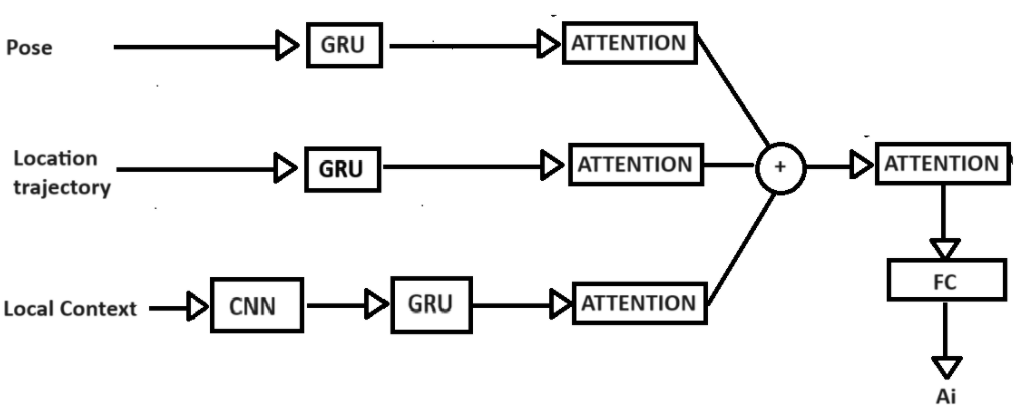

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np

# Feature Extractor using MobileNetV2
class MobileNetV2_FeatureExtractor(nn.Module):
    def __init__(self, weights='DEFAULT'):
        super(MobileNetV2_FeatureExtractor, self).__init__()
        mobilenet_v2 = models.mobilenet_v2(weights=weights)

        # Using the features up to the penultimate "bottleneck"
        self.features = mobilenet_v2.features

        # Applying AdaptiveAvgPool2d to reduce the spatial dimension to (1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Adding a fully connected layer to reduce to 512
        self.fc = nn.Linear(mobilenet_v2.last_channel, 512)

    def forward(self, x):
        # Resizing the input from [batch_size, 3, 224, 224] to [batch_size, 3, 96, 96]

        x = torch.nn.functional.interpolate(x, size=(96, 96))  # Resize using interpolation

        # Feature extraction
        x = self.features(x)  # Output: [batch_size, 1280, 4, 4]
        x = self.avgpool(x)    # Output: [batch_size, 1280, 1, 1]
        x = torch.flatten(x, 1)  # Flattening the output: [batch_size, 1280]
        x = self.fc(x)  # Reducing the output to: [batch_size, 512]
        return x

# GRU Module
class GRU_Module(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU_Module, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

    def forward(self, x):
        # Input: [batch_size, sequence_length, input_size]
        output, hidden = self.gru(x)  # Output: [batch_size, sequence_length, hidden_size]
        return output, hidden

# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionModule, self).__init__()
        self.Ws = nn.Linear(hidden_dim, hidden_dim)
        self.Wc = nn.Linear(2 * hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate

    def forward(self, h, hidden_states):
        # Input: h: [batch_size, hidden_dim], hidden_states: [batch_size, sequence_length, hidden_dim]
        scores = torch.matmul(hidden_states, self.Ws(h).unsqueeze(-1)).squeeze(-1)  # Output: [batch_size, sequence_length]
        alpha = F.softmax(scores, dim=1)  # Output: [batch_size, sequence_length]
        alpha = alpha.unsqueeze(1)  # Output: [batch_size, 1, sequence_length]

        h_c = torch.bmm(alpha, hidden_states)  # Output: [batch_size, 1, hidden_dim]
        h_c = h_c.squeeze(1)  # Output: [batch_size, hidden_dim]
        V_attention = torch.tanh(self.Wc(torch.cat((h_c, h), dim=1)))  # Output: [batch_size, hidden_dim]
        V_attention = self.dropout(V_attention)  # Output: [batch_size, hidden_dim]
        return V_attention

# Reduced Attention Module (with temperature scaling)
class ReducedAttentionModule(nn.Module):
    def __init__(self, hidden_dim):
        super(ReducedAttentionModule, self).__init__()
        self.Ws = nn.Linear(hidden_dim, hidden_dim)
        self.Wc = nn.Linear(2 * hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate

    def forward(self, h, hidden_states):
        # Input: h: [batch_size, hidden_dim], hidden_states: [batch_size, sequence_length, hidden_dim]
        scores = torch.matmul(hidden_states, self.Ws(h).unsqueeze(-1)).squeeze(-1)  # Output: [batch_size, sequence_length]
        alpha = F.softmax(scores / 2.0, dim=1)  # Temperature scaling
        alpha = alpha.unsqueeze(1)  # Output: [batch_size, 1, sequence_length]

        h_c = torch.bmm(alpha, hidden_states)  # Output: [batch_size, 1, hidden_dim]
        h_c = h_c.squeeze(1)  # Output: [batch_size, hidden_dim]
        V_attention = torch.tanh(self.Wc(torch.cat((h_c, h), dim=1)))  # Output: [batch_size, hidden_dim]
        V_attention = self.dropout(V_attention) * 0.5  # Scaling output by 0.5
        return V_attention

# Main Classifier for Pedestrian Crossing
class PedestrianCrossingClassifier(nn.Module):
    def __init__(self):
        super(PedestrianCrossingClassifier, self).__init__()

        # Vision Branch
        self.cnn = MobileNetV2_FeatureExtractor()  # Feature extractor using MobileNetV2
        self.visual_gru = GRU_Module(512, 256)  # GRU for visual features
        self.visual_attention = AttentionModule(256)  # Attention for visual features

        # Pose Branch
        self.pose_gru = GRU_Module(36, 256)  # GRU for pose features (input size: 36)
        self.pose_attention = ReducedAttentionModule(256)  # Reduced Attention for pose features

        # BBox Branch
        self.bbox_gru = GRU_Module(4, 256)  # GRU for bounding box features (input size: 4)
        self.bbox_attention = AttentionModule(256)  # Attention for bounding box features

        # Final Fusion
        self.final_attention = AttentionModule(256)  # Final attention mechanism for fused features
        self.fc = nn.Sequential(  # Fully connected layers for final output
            nn.Linear(256 * 3, 256),  # Input size: 256*3 (3 branches)
            nn.ReLU(),
            nn.Linear(256, 1)  # Final output size: 1 (binary classification)
        )

        # Defining transformations for data augmentation
        self.transforms_available = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        ]

    def forward(self, pose, bbox, frame):
        # Processing Visual Data
        batch_size, sequence_length, h, w, c = frame.shape  # Input frame shape

        # Reshaping: [batch_size * sequence_length, 3, 224, 224]
        frame = frame.view(batch_size * sequence_length, h, w, c).permute(0, 3, 1, 2)

         # Applying random transformations if in training mode for data augmentation
        if self.training:
            # Select a random number of transformations to apply (from 0 to len(transforms_available))
            num_transforms = random.randint(0, len(self.transforms_available))
            selected_transforms = random.sample(self.transforms_available, num_transforms)

            for i in range(frame.size(0)):
                for transform in selected_transforms:
                    frame[i] = transform(frame[i])  # Apply each selected transformation

        # Visual Feature Extraction
        visual_features = self.cnn(frame)  # Output: [batch_size * sequence_length, 512]
        visual_features = visual_features.view(batch_size, sequence_length, -1)  # Output: [batch_size, sequence_length, 512]

        # Visual GRU Processing
        visual_gru_output, _ = self.visual_gru(visual_features)  # Output: [batch_size, sequence_length, 256]
        visual_attention_output = self.visual_attention(visual_gru_output[:, -1, :], visual_gru_output)  # Output: [batch_size, 256]

        # Processing Pose Data
        pose_gru_output, _ = self.pose_gru(pose)  # Output: [batch_size, sequence_length, 256]
        pose_attention_output = self.pose_attention(pose_gru_output[:, -1, :], pose_gru_output)  # Output: [batch_size, 256]

        # Processing BBox Data
        bbox_gru_output, _ = self.bbox_gru(bbox)  # Output: [batch_size, sequence_length, 256]
        bbox_attention_output = self.bbox_attention(bbox_gru_output[:, -1, :], bbox_gru_output)  # Output: [batch_size, 256]

        # Final Fusion of Features
        visual_features_exp = visual_attention_output.unsqueeze(1)  # Output: [batch_size, 1, 256]
        pose_features_exp = pose_attention_output.unsqueeze(1)  # Output: [batch_size, 1, 256]
        bbox_features_exp = bbox_attention_output.unsqueeze(1)  # Output: [batch_size, 1, 256]

        # Concatenating along the sequence length dimension
        combined_features = torch.cat((visual_features_exp, pose_features_exp, bbox_features_exp), dim=1)  # Output: [batch_size, 3, 256]

        # Applying final attention
        final_attention_output = self.final_attention(combined_features[:, -1, :], combined_features)  # Output: [batch_size, 256]

        # Final classification
        final_features = torch.cat((visual_attention_output, pose_attention_output, bbox_attention_output), dim=-1)  # Output: [batch_size, 256 * 3]
        output = self.fc(final_features)  # Output: [batch_size, 1]

        return output


⚓Here the training using the Adam optimizer withlearning rate = 1e-4,batch size = 1 and a weight_decay=0.01.

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch.optim as optim

# Defining the function for saving the model
def saving_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
    }, checkpoint_path)
    print(f"Saving model at the end of epoch {epoch + 1}")

# Defining the function for loading the model
def loading_checkpoint(model, optimizer, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch'] + 1  # Resuming from the next epoch
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        print(f"Loading model from epoch {epoch}")
        return epoch, best_val_loss
    return 0, float('inf')  # Starting from scratch if no checkpoint is found

# Defining the training function
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, checkpoint_path, patience, device):
    best_val_loss = float('inf')  # Initializing the best validation loss
    patience_counter = 0  # Counter for early stopping

    # Loading the checkpoint if it exists
    start_epoch, best_val_loss = loading_checkpoint(model, optimizer, checkpoint_path)

    for epoch in range(start_epoch, num_epochs):  # Iterating over epochs
        model.train()  # Setting the model to training mode
        total_loss = 0.0

        for batch in train_loader:
            poses = batch[0].to(device)
            bboxes = batch[1].to(device)
            frames = batch[2].to(device)
            labels = batch[3].to(device)

            optimizer.zero_grad()  # Zeroing the gradients

            # Forward passing the data through the model
            outputs = model(poses, bboxes, frames)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())  # Calculating the loss

            loss.backward()  # Backward passing to compute gradients
            optimizer.step()  # Updating the model parameters

            total_loss += loss.item()  # Accumulating the loss

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Evaluating the model
        model.eval()  # Setting the model to evaluation mode
        total_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disabling gradient calculation for validation
            for val_batch in val_loader:
                poses_val = val_batch[0].to(device)
                bboxes_val = val_batch[1].to(device)
                frames_val = val_batch[2].to(device)
                labels_val = val_batch[3].to(device)

                outputs_val = model(poses_val, bboxes_val, frames_val)
                labels_val = labels_val.unsqueeze(1)
                val_loss = criterion(outputs_val, labels_val.float())
                total_val_loss += val_loss.item()

                probs_val = torch.sigmoid(outputs_val).cpu().numpy()
                preds_val = (probs_val > 0.5).astype(int)
                all_preds.extend(preds_val)
                all_labels.extend(labels_val.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")

        f1 = f1_score(all_labels, all_preds, average='binary')
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='binary')
        recall = recall_score(all_labels, all_preds, average='binary')

        print(f"Metrics - F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        # Saving the model at the end of each epoch
        saving_checkpoint(model, optimizer, epoch, best_val_loss, checkpoint_path)

        # Implementing early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Resetting the patience counter
        else:
            patience_counter += 1  # Incrementing the patience counter
            print(f"Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}!")
            break


drive.mount('/content/drive')

# Create the directory for the checkpoint if it doesn't exist
checkpoint_dir = '/content/drive/My Drive/Pedestrian_model_checkpoint'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the filename for the checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pth')

# Setting the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initializing the model and moving it to the device
model = PedestrianCrossingClassifier().to(device)

# Defining the optimizer
learning_rate = 1e-4
weight_decay = 0.01

# Separate parameters for weight decay
fc_params = list(model.fc.parameters())
other_params = [param for name, param in model.named_parameters() if 'fc' not in name]

# Set weight decay only for the FC layer parameters
optimizer = optim.Adam([
    {'params': other_params, 'weight_decay': 0},
    {'params': fc_params, 'weight_decay': weight_decay}  # Weight decay for FC layer
], lr=learning_rate)


# Defining the loss function
criterion = nn.BCEWithLogitsLoss()

# Training the model
num_epochs = 50  # Setting the number of epochs
patience = 4  # Setting the patience for early stopping

train_model(model, train_data_loader, val_data_loader, num_epochs,criterion,optimizer ,checkpoint_path, patience,device)
